<font color = '#0051ba'>
<img height="60" width="120" src="../Graphics/UR_Logo.jpg" > 



<p align="center">

# Residential Real-Estate Spot-Market Pricing Model for Ames, IA.

</p>

</font>

<font color = '#003459'>

### Client:  SlumRock Partners, LLP
### Deliverable:  Interim Report
    
</font>

### Overview.

This logic provides Uncertainty Research client SlumRock Partners with a Spot-Market Pricing Model for residential real estate.  SlumRock initiated a fund to follow other hedge funds in to the residential real-estate rental market.  The business model is described in [R. Dizember, L. Kuzisto, *WSJ*, July 21, 20176](https://www.wsj.com/articles/meet-your-new-landlord-wall-street-1500647417) and [A. Semiuels, *The Atlantic*, February 13, 2019](https://www.theatlantic.com/technology/archive/2019/02/single-family-landlords-wall-street/582394/), among other places. 

This logic estimates housing-market spot prices using a subset of 216 available explanatory variables. The high-level workflow follows.

🅐 **Read in and cleanse data**.  We read in the data and address basic heigene issues. We also generate a data-dictionary template, which is exported to a csv file.  We further elaborate on data characteristics in that data dictionary.  

🅑 **Perform data preparation**.  The populated data dictionary is read in and employed by the logic to apply additional preparatory activities.  This includes decisions about which explanatory variables to discard up front, and how to handle null values.

🅒 **Influential-variable analysis**.  Ascertain which variables are most-likely influential for our response variable `SalePrice`.  We have three classes of variables.

⓵ <span style="text-decoration:underline">Continuous Numeric Variables</span>.  Straightforwardly, the degree of influence for continuous numeric variables is directly related to their colinearity — e.g,. correlation — with the response variable.  These variables are judged to be influential if the correlation $\rho_{x_{i,j}, y_i }\gtrapprox 0.45$.  This relatively low threshold offers a starting point, from which the initial model is likely overfit.

⓶ <span style="text-decoration:underline">Discrete Numeric Variables</span>.  We emply the same criteria for discrete explanatories as for continuous.  These variables are judged to be influential if the correlation $\rho_{x_{i,j}, y_i }\gtrapprox 0.45$.  

⓷ <span style="text-decoration:underline">Categorical Variables</span>.  A definition of colinearity between discrete and continuous variables does not exist.  We can however think about using the reciprocal problem as indicating extent of influence. That is, if our continouous response variable by itself predicts the categoricals, then the latter must be influential of the former.  So, we construct a univariate multinomial logistic model for each explanatory categorical to see how well the continouous response variable `SalePrice` predicts them. Categoricals are deemed influential if the score of the associated model $\gtrapprox 0.65$.


🅓 **Feature engineering.** We split the data into training and test steps. We then perform feature engineering.

⓵ We expand our categorical variables into dummy variables.

⓶ We expand our numeric — continouous and discrete — variables into second-order polynomials.

⓷ We then standardize the scale.

🅔 **Model Development**.  Our consideration here is limited to linear models.  We explore four variaants.

⓵ Ordinary Least Squares.  

⓶ Ridge regression.

⓷ Lasso regression.

⓸ ElasticNet regression.

In all cases we contribute basic analysis-of-variance (ANOVA) and related scoring, e.g., Coefficient of Determination $R^2$.  With the OLS, we also confidence intervals and significance tests (p-values).  We also look at response and residual plots [Olive, 2017, §2.1](https://www.springer.com/gp/book/9783319552507).  Adding Locally-Weigthed Scatter-plot Smoothing (LOWESS) [Olive, 2017, §2.2](https://www.springer.com/gp/book/9783319552507) gives us a sense of the model's bias.

🅕 **Model Iteration**. Based on ANOVA and -related scores, we select the Ridge-regression as the baeline approach.  Our model's residuals turn out to be outlier-dominated.  Our coefficients of variation for training and test are $R_\text{train}^2 \approx 0.88$ and $R_\text{test} \approx 0.81$, respectively.  The LOWESS curves deviate modestly from the ideal response and residual curves.

Our iteration focuses on these outliers.  We remove variables a few at at time — mostly interaction variables for which phenomenological justificaiton doesn't seem obvious.  We get to the point at which `GrLivArea`, above-grade living space, dominates.  

🅖 **Model Interpretation**. Once phenomenologically justifiable explanatory dominate our outliers' residuals, we turn to model interpretation.  Our model — except for a small number ($\lesssim 3-4$ ) outliers — explains the `SalePrice` response variable relatively well.  We look at the specific outliers. They are large-footprint (`GrLivArea`) properties in a `Neighborhood` `Edwards` for which prices are low for the market.  We do not have evidence to justify discarding these measurements.

Additionally, our model overestimates prices at the upper end of the market.  This is a limitation of linearity.




In [1]:
#Imports:
import pandas as pd
import numpy as np
from collections import Counter
import pandas as pd
import scipy.stats as stats
import os, io
import matplotlib.pyplot as plt
from matplotlib import cm
import functools as fct
import seaborn as sns
import itertools as it
import scipy as sci
from scipy.stats import skew, anderson, kstest
import math as mt
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.feature_selection import f_regression
import statsmodels.api as sm
from copy import deepcopy
from scipy.constants import golden
from metalog import metalog

from statsmodels.distributions.empirical_distribution import ECDF

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from statsmodels.nonparametric.smoothers_lowess import lowess
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor, NearestNeighbors
from sklearn.linear_model import LogisticRegression


data_source_dir = '/Users/nhamlett/Documents/GitHub/UncertaintResearch/MathStats/data'



In [2]:
#
# Partition a list into a specified number of bins.  Our inputs
# are:
# ⧐ parted_list is the list to be partitioned;
# ⧐ partition_counts specifies the number of bins into which
#   parted_list is divided.
# We produce an enumerated dictionary of the list partitions.
def partition_list(parted_list, partition_counts):
    parted_list = np.sort(np.array(parted_list))
    partition_len = int(np.ceil(len(parted_list)/partition_counts))
    partitions = [np.array(object = range(partition_len)) + part * partition_len
                     for part in range(partition_counts)]
    partitions[-1] = np.arange(start = partitions[-1][0],
                               stop = parted_list.shape[0])
    return dict(enumerate([list(parted_list[part])
                             for part in partitions]))
#
# CALCULATE ANALYSIS-OF-VARIANCE (ANOVA) STATISTICS for a given
# observation-estimate pair.  We calculate Total Sum of Suares,
# Error Sum of Squaresm, Regression Sum of Squares, and 
# coefficient of deternination in accordance with 
# [Dielman, 2005, pp. 94 - 96].
def anova(y_observed, y_estimated):
    # Total sum of squares.
    SST = np.square(y_observed - y_observed.mean()).sum()
    #
    # Error sum of squares.
    SSE = np.square(y_observed - y_estimated ).sum()
    #
    # Regression sum of squares.
    SSR = np.square(y_estimated - y_observed.mean()).sum()
    #
    # Coefficient of determination.
    R2 = 1 - SSE/SST
    #
    return {'root_SST' : np.sqrt(SST),
            'root_SSE' : np.sqrt(SSE),
            'root_SSR' : np.sqrt(SSR),
            'SST-SSE-SSR' : SST - SSE - SSR,
            'R2' : R2}
#
# Generate a 2×2 grid of Response, Residual plots. Our inputs are:
# ⧐ y_train, a vector training-data-set observed, response variables;
# ⧐ y_test, a vector test-data-set observed, response variables;
# ⧐ fit_train, a vector training-data-set estimated, response variables;
# ⧐ fit_test, a vector test-data-set estimated, response variables; and
# ⧐ plot_title, a text string for the "suptitle" label.
def response_residual_plots(y_test, y_train, fit_test, fit_train, plot_title):
    # Encapsulate our inputs into a dictionary. This makes managing simpler
    # with subsequent control loops.
    resp_resid = {'y_train' : y_train,
                  'y_test' : y_test,
                  'fit_train' : fit_train,
                  'fit_test' : fit_test,
                  'resid_train' : y_train - fit_train,
                  'resid_test' : y_test - fit_test}
    #
    # Initialize the plot.  We define a 2×2 subplot arrangement.  Encapsulate our
    # labels and plot axes into dictionaries.
    fig, axes = plt.subplots(2, 2, figsize = (15, 7.5))
    plt_axes = dict(enumerate(np.ndarray.flatten(axes)))
    title_params = dict(enumerate(it.product(['Response', 'Residual'],
                                             ['training', 'test'])))
    yaxis_labels = dict(enumerate(2 * ['Estimate, $\hat{y}_i$'] + 2 * ['Residual, $\epsilon_i$']))
    xaxis_labels = dict(enumerate(2 * ['Observed, $y_i$'] + 2 * ['Estimated, $\hat{y}_i$']))
    #
    # Construct an enumerated dictionary specifying our paired plots.
    plot_var_pairs = dict(enumerate([('y_train', 'fit_train'),
                                     ('y_test', 'fit_test'),
                                     ('fit_train', 'resid_train'),
                                     ('fit_test', 'resid_test')]))
    #
    # Now, cycle through each plot axis and instantiate the plot.
    for axis_idx in plt_axes.keys():
        # According to [Olive, 2017] we want to compare our scatters with
        # an identity line or horizontal-axis line for response, residuals,
        # respectively.  Conditionally instantiate these features.
        if title_params.get(axis_idx)[0] == 'Residual':
        # Add a LOWESS curve.
            resp_lowess = sm.nonparametric.lowess
            lowess_curve =  resp_lowess(endog = resp_resid.get(plot_var_pairs.get(axis_idx)[1]),
                                        exog = resp_resid.get(plot_var_pairs.get(axis_idx)[0]))
            plt_axes.get(axis_idx).plot(lowess_curve[:,0],
                                        lowess_curve[:,1],
                                        color = '#f2a900',
                                        label = 'LOWESS')
            plt_axes.get(axis_idx).axhline(color = '#e8000daa',
                                           label = '$\epsilon_i = 0$')
            # Plot the scatter plots.
            plt_axes.get(axis_idx).scatter(resp_resid.get(plot_var_pairs.get(axis_idx)[0]),
                                           resp_resid.get(plot_var_pairs.get(axis_idx)[1]),
                                           color = '#2767ff',
                                           s = 5,
                                           label = '$(\hat{y}_i,\,\epsilon_i)$')
            plt_axes.get(axis_idx).legend(loc = 'best',
                                          edgecolor = '#003459',
                                          fontsize = 14)
            #
        else:
            resp_lowess = sm.nonparametric.lowess
            lowess_curve =  resp_lowess(endog = resp_resid.get(plot_var_pairs.get(axis_idx)[1]),
                                        exog = resp_resid.get(plot_var_pairs.get(axis_idx)[0]))
            plt_axes.get(axis_idx).plot(lowess_curve[:,0],
                                        lowess_curve[:,1],
                                        color = '#f2a900',
                                        label = 'LOWESS')
            plt_axes.get(axis_idx).plot([0, min(max(resp_resid.get(plot_var_pairs.get(axis_idx)[0])),
                                                max(resp_resid.get(plot_var_pairs.get(axis_idx)[1])))],
                                        [0, min(max(resp_resid.get(plot_var_pairs.get(axis_idx)[0])),
                                                max(resp_resid.get(plot_var_pairs.get(axis_idx)[1])))],
                                        color = '#e8000daa',
                                        label = '$\hat{y}_i = y_i$')
            # Plot the scatter plots.
            plt_axes.get(axis_idx).scatter(resp_resid.get(plot_var_pairs.get(axis_idx)[0]),
                                           resp_resid.get(plot_var_pairs.get(axis_idx)[1]),
                                           color = '#2767ff',
                                           s = 5,
                                           label = '$(y_i,\,\hat{y}_i)$')
            plt_axes.get(axis_idx).legend(loc = 'best',
                                          edgecolor = '#003459',
                                          fontsize = 14)
            #
        #
        # Apply plot labels.
        plt_axes.get(axis_idx).set_title(label = '{} plot, {} data'\
                                                    .format(*title_params.get(axis_idx)),
                                         color = '#0051ba',
                                          fontsize = 24)
        plt_axes.get(axis_idx).set_xlabel(xlabel = xaxis_labels.get(axis_idx),
                                          fontsize = 20)
        plt_axes.get(axis_idx).set_ylabel(ylabel = yaxis_labels.get(axis_idx),
                                          fontsize = 20)
        #
    # Apply the plot super title.
    plt.suptitle(t = plot_title,
                 va = 'top',
                 y = .9675,
                 color = '#003459',
                 fontsize = 24,
                 weight = 'bold');
    fig.subplots_adjust(wspace = 0.25)
    fig.subplots_adjust(hspace = 0.475)
    return
#
# Perform manual cross-validation.  Particularly when we have
# categorical explanatory variables with large numbers of categories,
# we may get singularities in the sum-squares and -cross-roducts
# SSCP matrix. The 'canned' sklearn.model_selection.cros_val_score  
# fails to check for this. Here, we drop from our explanatory-
# variable data matrix attributes for which we have no
# finite values.  This provides for a stable model.
#
# Our inputs are:
# ⧐ X is the matrix of explanatory variables;
# ⧐ y is the observed response variables corresponding to X; and
# ⧐ cv is the number of cross-validation folds to perform.
#
# We return a dictionary with the ANOVA statistics for each.
#
def manual_cross_val_anova(X, y, cv):
    # ⓵ Partition the explanatory-variable dataframe indices into
    #    "cv" partions.  We have to account for the occurrence
    #    of an uneven partitions, if the length of our
    #    data matrix is a noninteger multiple of our "cv".
    X = X.reset_index(drop = True)
    y = y.reset_index(drop = True)
    part_len = int(np.ceil(len(X)/cv))
    partitions = [np.array(object = range(part_len)) + part * part_len
                     for part in range(cv)]
    partitions[-1] = np.arange(start = partitions[-1][0],
                               stop = X.shape[0])
    partitions = dict(enumerate(partitions))
    cross_val_anova = dict()
    # estimator.set_params(fit_intercept = True)
    #
    # ⓶ Now cycle through each partition.  The indices in each
    #    partition comprise our test data set.  So we drop those
    #    indices for the training set.  
    #    ⓐ Explicitly instantiate test and training data sets.
    part_idx = list(partitions.keys())[-1]
    for part_idx in partitions.keys():
        X_train = X.drop(labels = partitions.get(part_idx),
                         axis = 0)\
                   .assign(intercept = 1)
        y_train = y.drop(labels = partitions.get(part_idx),
                         axis = 0)
        X_test = X.loc[partitions.get(part_idx)]\
                   .assign(intercept = 1)
        y_test = y.loc[partitions.get(part_idx)]
        #
        #    ⓑ Identify columns in X_train for which all values are nonzero.
        #       We sum down the columns and check for nonzero results.
        #       This boolean result allows us to index into the columns
        #       of X_train to get the columns with nonzero vaues.
        finite_train_attributes = X_train.columns[(X_train.sum(axis = 0)!=0)]
        #
        #    ⓒ Train the model to the X_train, y_train, using only the
        #       finite-valued columns in the former.
        beta = sci.linalg.lstsq(a = X_train[finite_train_attributes],
                               b = y_train)[0]
        #estimator.fit(X = X_train[finite_train_attributes],
        #              y = y_train);
        #
        #    ⓓ Now, pass the predictions using X_test
        #       to the locally-defined function anova. Add the results to
        #       our dictionary cross_val_anova using the dictionary.update method.
        cross_val_anova.update(
            {part_idx : anova(y_estimated = np.dot(a = X_test[finite_train_attributes],
                                                   b = beta),
                              y_observed = y_test)})
    return cross_val_anova


housing_raw<font color = '#0051ba'>

##  Data Cleansing and Exploratory Data Analysis (EDA).

</font>

🅐 DATA CLEANSING.

Our data cleansing and EDA result from an iterative process. This documentation begins after the first iteration.  Specifically, we describe undocumented activities performed during previous iterations.

This includes analysis documented in our data dictionary [(data_dictionary_populated.csv)](https://git.generalassemb.ly/hamlett-neil-ga/project_2/blob/master/datasets/data_dictionary_populated.csv). Or data dictionary is read in in cell 🅑, below.  We constructed it by annotating a template created by applying the pandas.DataFrame.info() method to our raw data from the [train.csv](https://git.generalassemb.ly/hamlett-neil-ga/project_2/blob/master/datasets/train.csv) "raw" data file.

Our data dictionary includes attribute information from the [data_description.txt](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data) file at the Kagggle website. We transferred this information into the *Notes* column of our data dictionary. We reviewed the data attribute-by-attribute. We identified each attribute as categorical, numerical, or unique ID (primary key). 

Our data dictionary also contains a *disposition* column.  This contains judgements about the disposition of records — or of overall atrributes themselves — based completeness, other conditions.  Based on these pieces of information in the data dictionary, we are able to apply our cleansing actions using python logic.

This analysis influenced some of the specifications used by the `pandas.read_csv()` method to read in the raw data set [train.csv](https://git.generalassemb.ly/hamlett-neil-ga/project_2/blob/master/datasets/train.csv).  Specifically, the string `NA` is extensively used for "not applicable."  Pandas' default behavior is to interpret this as `Null`. So we select `keep_default_na = False` to inhibit this behavior.  We find in our csv file — through visual inspection in a text editor — that missing values are actually blanks `''`. We therefore specify the option `na_values = ['']` in our `pandas.read_csv()` statement.

In [3]:
# Read in the data.  Immediately upon reading, rename of the columns, 
# replacing spaces in column names with underbars. We do this because spaces
# in column names are inconvenient, if not downright evil 👹👺😈
housing_raw = pd.read_csv(filepath_or_buffer = '../data/train.csv',
                          keep_default_na = False,
                          na_values = ['']).set_index(keys = 'PID',
                                                          drop = False)
housing_raw.rename(columns = dict(zip(housing_raw.columns,
                                       housing_raw.columns.str.replace(' ',''))),
                   inplace = True)
housing_raw.rename(columns = dict(zip(housing_raw.columns,
                                       housing_raw.columns.str.replace('/',''))),
                   inplace = True)

In [4]:
# Construct *Date_sold* attribute. Our raw data (train.csv) contains distinct 
# attributes for year sold and month sold. We want our sell date to be a 
# serial numeric variable. Converting it explicitly to a datetime object
# is inconvenient. Datetime objects present difficulties in plotting and as
# explanatory variables for regression.
#
# We instead create a YYYYMM attribute and call it "Sell_date". This takes 
# a wee bit of string-manipulation work.  We first concatenate Yr_Sold and
# Mo_Sold as strings.  We then convert the results back to a numeric.
# The built-in function "zfill" provides a very-convenient way to prepend 
# zeros to our single-digit months.
housing_raw = housing_raw.assign(Sell_date = lambda Ξ : [int(str(yr) + str(mo).zfill(2))
                                                            for (yr, mo) in Ξ[['YrSold', 'MoSold']].to_records(index = False)],
                                 GrLivAreaLarge = lambda Ζ : ['large' if area >= 3000
                                                              else 'normal'
                                                              for area in Ζ['GrLivArea']])

In [5]:
# Use substrings in notes to classify attribute type as either
# numeric, discrete, categorical, or ID.  This operates on the
# "Notes" attribute of the data dictionary.
def classify_attribute(note):
    if 'Categorical'.lower() in note.lower():
        return 'Categorical'
    elif 'Discrete'.lower() in note.lower():
        return 'Discrete' 
    elif 'Numeric'.lower() in note.lower():
        return 'Continuous'
    elif 'target' in note.lower():
        'Target'
    else:
        return 'Primary_key'

In [6]:
%%capture
# 🅑 CONSTRUCT DATA DICTIONARY.
# We want to parse the pandas.DataFrame.info()  output so as to create
# an structured object that can be exported into a csv for use as a 
# data dictionary. 
#
# We use the io.StringIO() method to "scrape" the printed output into 
# a single character string. We then perform a series of splits.
# ⓵ We split by the new-line character "\n" and get a list of
#    substrings, each of which corresponds to a set of metadata
#    about an attribute.
# ⓶ We truncate the first two and last two substrings. These contain
#    output-object explanatory information that doesn't concern us.
# ⓷ Next, we split each of these substrings by a single space.  We keep
#    non-zero-length sub-substrings from each of the substrings. Since
#    we had the foresight to replace all spaces in our attribute names
#    with underscores, we have a regular list.
# ④ Capture the results into a pandas.DataFrame() object and write to csv.
# ⓹ Read in the modified data dictionary.
# buffer = io.StringIO()
# housing_raw.info(buf = buffer)
# s = buffer.getvalue()
# housing_profile_info = pd.merge(left = pd.DataFrame(data = [[substring
#                                                               for substring in string_line.split(' ')
#                                                               if len(substring) > 0]
#                                                                 for string_line in s.split('\n')[3:-3]],
#                                                 columns = ['attribute_name','non_null_records',
#                                                            'non_null', 'type'])\
#                                         .drop(labels = 'non_null',
#                                               axis = 1)\
#                                         .set_index(keys = 'attribute_name'),
#                                 right = pd.DataFrame(data = housing_raw.apply(func = lambda ζ : len(set(ζ)),
#                                                                                   axis = 0),
#                                                      columns = ['distinct_values']),
#                                 left_index = True,
#                                 right_index = True).assign(Notes = '')\
#                                                    .rename_axis(index = 'attribute')
# housing_profile_info.to_csv(path_or_buf = os.path.join('./datasets',
#                                                        'data_dictionary_template.csv'),
#                             index = True)
#
# ⓺ Read in the modified data dictionary.
data_dict_populated = pd.read_csv(filepath_or_buffer = os.path.join('../data',
                                                                    'data_dictionary_populated.csv'))\
                                    .fillna(value = 'Use as provided')\
                                    .assign(cat_vars = lambda Ξ : [classify_attribute(note)
                                                                         for note in Ξ['Notes']])

# data_dict_md_writer = MarkdownTableWriter()
# data_dict_md_writer.tabel_name = 'Aimes, IA Housing-Data Quality Assessment'           # Construct markdown table in
# data_dict_md_writer.headers = data_dict_populated.columns.tolist()                    # accordance with package
# data_dict_md_writer.value_matrix = np.ndarray.tolist(data_dict_populated.to_numpy())  # documentation.
# data_dict_md_writer.write_table()
ames_feature_cats = data_dict_populated.groupby(by = 'cat_vars')\
                                       .count()\
                                       ['attribute']



<font color = '#0051ba'>

We now do the data cleansing. We identified two attributes — `Lot_Frontage` and `Garage_Yr_Blt` — to be discarded. These attributes have substatial portions of missing values.  `Garage_Yr_Blt` in particular is very-closely correlated with `YearBuilt` attribute.  No obvious approach to attributing value to `Lot_Frontage` occurs.  We identified a small number of records for which no obvious approach to attributing missing values occured.

We use `pandas.DataFrame.dropna()` method to discard records. We select the records by specifying the `subset` option. Our `subset` is indicated by the presence of a `Drop record` statement in the `disposition` column of `data_dict_populated`. 

We drop attributes using the `pandas.DataFrame.drop(axis = 1)` method.
               
</color>

In [7]:
# Discard attributes
discarded_attributes =\
data_dict_populated.set_index(keys = 'attribute')\
                   .loc[['Discard attribute' in disposition 
                         for disposition in data_dict_populated['Disposition']]]\
                   .index\
                   .tolist()
discarded_records =\
data_dict_populated.set_index(keys = 'attribute')\
                   .loc[['Discard records' in disposition 
                         for disposition in data_dict_populated['Disposition']]]\
                   .index\
                   .tolist()
#
# Cleans, transform data.
housing_profile = housing_raw.dropna(axis = 0,
                                     how = 'any',
                                     subset = discarded_records)\
                             .drop(labels = discarded_attributes,
                                   axis = 1)\
                             .dropna(axis = 0,
                                     how = 'any')\
                             .set_index(keys = 'Id')
housing_profile = housing_raw.drop(labels = discarded_attributes,
                                   axis = 1)\
                             .set_index(keys = 'Id')



In [8]:
# We have attributes with null values.  We conditionally attribute values
# based on the dataype.  Construct a dictionary for which the 
# keys are the attribute labels (column labels) with which null
# values and the values are the datatype. We cycle through each
# attribute and apply an pandas.DataFrame.fillna() method.  For 
# dype = "object", we apply "unspecified". We apply zeros
# for dtype = "float64"
attributes_with_nulls =\
pd.merge(left = pd.DataFrame(data = housing_profile.dtypes,
                             columns = ['dtypes']),
         right = pd.DataFrame(data = housing_profile.isna().any(axis = 0),
                              columns = ['has_nulls']),
         left_index = True,
         right_index = True).rename_axis(index = 'attribute')\
                            .reset_index(drop = False)\
                            .set_index(keys = 'has_nulls')\
                            .loc[True]\
                            .assign(dtypes = lambda Ξ : Ξ['dtypes'].apply(func = str))\
                            .set_index(keys = 'attribute')\
                            .to_dict()\
                            .get('dtypes')

for (attribute, dtype) in attributes_with_nulls.items():
    if dtype == 'object':
        housing_profile[attribute].fillna(value = 'unspecified',
                                          inplace = True)
    else:
        housing_profile[attribute].fillna(value = 0,
                                          inplace = True)




In [9]:
# Now, begin visualizing Response-variable SalesPrice by 
# data types, attributes. We begin with categoricals.  We
# identify our categoricals by their designation in the
# data dictionary.
categoricals = data_dict_populated.set_index(keys = 'attribute',
                                             drop = False)\
                                  .sort_index(axis = 0)\
                                  .set_index(keys = 'cat_vars',
                                             drop = False)\
                                  .loc['Categorical', 'attribute']\
                                  .tolist()
categorical_paritions = partition_list(parted_list = categoricals,
                                       partition_counts = 3)


<font color = '#0051ba'>

## 🅒 **Influential-variable analysis**.  Ascertain which variables are most-likely influential for our response variable `SalePrice`.  We have three classes of variables.
    
</font>

In [10]:
## 🧭🌡⏳🧭🌡⏳🧭🌡⏳🧭🌡⏳🧭🌡⏳🧭🌡⏳🧭🌡⏳🧭🌡⏳🧭🌡⏳🧭🌡⏳🧭🌡⏳ ##
# Identify influential categorical variables. Solve the reciprocal problem.
# Categoricals are influential with sales price if price indicates the
# category.  Our reciprocal problem therefore is to solve a multinomial
# regression problem for each categorical to see how well the SalesPrice
# predicts it.  We take the categoricals for which the associated model
# accuracy scores above a specified threshold.
categ_by_price = dict()
cat_var = categoricals[0]
for cat_var in categoricals:
    cat_log_fit = LogisticRegression(multi_class = 'multinomial',
                                     solver = 'lbfgs')
    cat_log_fit.fit(X = housing_profile[['SalePrice']],
                    y = housing_profile[cat_var])
    categ_by_price.update({cat_var : cat_log_fit.score(X = housing_profile[['SalePrice']],
                                                       y = housing_profile[cat_var])})
influential_categoricals = set([key
                                for (key, val) in categ_by_price.items()
                                if val >= 0.55] + ['Neighborhood']).union({'GrLivAreaLarge'})

len(influential_categoricals)

33

In [11]:
#
# Now, we visualize our continuous numerical variables. We look at pair-plot
# scatters and at correlation heatmaps.
numericals =data_dict_populated.loc[['Discard attribute.' not in dispos
                                         for dispos in data_dict_populated['Disposition']]]\
                                .set_index(keys = 'cat_vars')\
                                .loc['Continuous', 'attribute']\
                                .tolist()


In [12]:
## 🧭🌡⏳🧭🌡⏳🧭🌡⏳🧭🌡⏳🧭🌡⏳🧭🌡⏳🧭🌡⏳🧭🌡⏳🧭🌡⏳🧭🌡⏳🧭🌡⏳ ##
# Identify influential continuous explanatory variables. These are variables for
# whith the correlation with the response variable exceeds a specified threshold.
sales_price_cont_corr = housing_profile[numericals + ['SalePrice']]\
                                      .corr()\
                                      .loc['SalePrice']
influental_continuous = sales_price_cont_corr.loc[(np.abs(sales_price_cont_corr) >= 0.45) &\
                                                   (np.abs(sales_price_cont_corr) != 1)].index.tolist()
influental_continuous

['GarageArea',
 'GrLivArea',
 'MasVnrArea',
 'TotalBsmtSF',
 'YearBuilt',
 'YearRemodAdd']

In [13]:
discretes = data_dict_populated.set_index(keys = 'attribute',
                                                  drop = False)\
                                .drop(labels = ['Id', 'PID', 'SalePrice'] +\
                                                discarded_attributes)\
                                .sort_index()\
                                .set_index(keys = 'cat_vars',
                                           drop = False)\
                                .loc['Discrete', 'attribute']\
                                .tolist()

discretes

['BedroomAbvGr',
 'BsmtFullBath',
 'BsmtHalfBath',
 'Fireplaces',
 'FullBath',
 'GarageCars',
 'HalfBath',
 'KitchenAbvGr',
 'OverallCond',
 'OverallQual',
 'TotRmsAbvGrd']

In [14]:
## 🧭🌡⏳🧭🌡⏳🧭🌡⏳🧭🌡⏳🧭🌡⏳🧭🌡⏳🧭🌡⏳🧭🌡⏳🧭🌡⏳🧭🌡⏳🧭🌡⏳ ##

sales_price_discr_corr = housing_profile[discretes + ['SalePrice']]\
                                      .corr()\
                                      .loc['SalePrice']
influental_discretes = sales_price_discr_corr.loc[(np.abs(sales_price_discr_corr) >= 0.45) &\
                                                   (np.abs(sales_price_discr_corr) != 1)].index.tolist()
influental_discretes

['Fireplaces', 'FullBath', 'GarageCars', 'OverallQual', 'TotRmsAbvGrd']

<font color = '#0051ba'>

## 🅓 **Feature engineering.** 

</font>

In [15]:
## 🐘🐫🐪🐎🐕🐂🐘🐫🐪🐎🐕🐂🐘🐫🐪🐎🐕🐂🐘🐫🐪🐎🐕🐂🐘🐫🐪🐎🐕🐂🐘🐫🐪🐎🐕🐂 ##
# FEATURE ENGINEERING.  Derive dummy variables for the influential categorical
# variables in both the training and unseen data.
sac_house_model_mtx0 = pd.get_dummies(
            data = housing_profile[set().union(*[influential_categoricals,
                                                  influental_continuous,
                                                  influental_discretes,
                                                 ['SalePrice']])],
            columns = influential_categoricals,
            drop_first = True)

#
sac_model_tts = dict(zip(['X_train', 'X_test', 'y_train', 'y_test'],
                         train_test_split(sac_house_model_mtx0.drop(labels = 'SalePrice',
                                                                    axis = 1),
                                          np.log(sac_house_model_mtx0['SalePrice']),
                                          train_size = 0.75,
                                          test_size = 0.25,
                                          random_state = 30214)))
sac_model_scaler = StandardScaler()
sac_model_scaler.fit(sac_model_tts.get('X_train'))
sac_model_tts.update({'X_train_scaled' : sac_model_scaler.transform(sac_model_tts.get('X_train')),
                      'X_test_scaled' : sac_model_scaler.transform(sac_model_tts.get('X_test'))})

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:   14.9s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:   29.1s finished


Train 𝘙² : 0.8573790878475954
Test 𝘙² : 0.869851707526087


{'max_depth': 13, 'min_samples_leaf': 3, 'min_samples_split': 3}

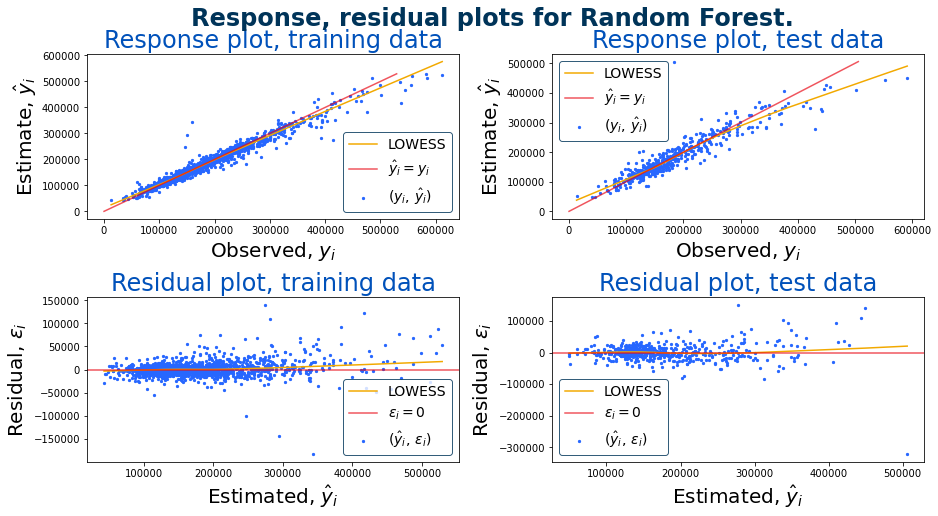

In [16]:
# Conduct a gridsearch over "tuning" parameters for a
# Random-forest Regressor.
ames_randfor_gs = GridSearchCV(estimator = RandomForestRegressor(random_state = 30214,
                                                                    n_estimators = 50,
                                                                    criterion = 'mse'),
                              param_grid = {'max_depth' : [12,13,14,15,16],
                                            'min_samples_split' : range(3,5),
                                            'min_samples_leaf' : range(3,5)},
                              refit = True,
                              cv = 5,
                              n_jobs = 10,
                              verbose = True)
ames_randfor_gs.fit(X = sac_model_tts.get('X_train'),
                    y = sac_model_tts.get('y_train'))
print('Train 𝘙² : {}\nTest 𝘙² : {}'
      .format(ames_randfor_gs.best_score_,
              ames_randfor_gs.score(X = sac_model_tts.get('X_test'),
                                    y = sac_model_tts.get('y_test'))))
response_residual_plots(y_test = np.exp(sac_model_tts.get('y_test')), 
                        y_train = np.exp(sac_model_tts.get('y_train')), 
                        fit_test = np.exp(ames_randfor_gs.predict(X = sac_model_tts.get('X_test') )), 
                        fit_train = np.exp(ames_randfor_gs.predict(X = sac_model_tts.get('X_train') )), 
                        plot_title = 'Response, residual plots for Random Forest.')
ames_randfor_gs.best_params_

<font color = '#0051ba'>

## 🅔 **Quantitative analysis of residuals.** 

</font>

Making decisions based upon statistical evidence begins recognizing the bounded certainty of the latter. Classical statistics addresses this through analysis of variance (ANOVA) [e.g., [Sahai2004](https://t.ly/R1hc), [Huberty2006](https://t.ly/M7ip)] and *residual analysis* [e.g., [Dielman2005](https://amz.run/4LdZ), [Olive2017](https://t.ly/i0S6)]. These methods involve assumptions about the statistical structure — families of distributions — of explanatory variables and resulting model parameters. This allows for sophisticated statistical inference about the explantory and predictive power. 

Machine learning (ML) abandons these statistical-structure assumptions, which often do not hold up well in reality anyway. Statistical inference — quantitative characterization about a model's explanatory and predictive power — becomes therefore problematic. Residual analyisis is not therefore generally attempted in ML practice. Quantative characterization of a model is limited to model scoring.  Model scores are often single-quantity statistics indicating goodness of fit. Such information is arguably too-compact for ML practitioners — let alone less-quantatively initiated consumers of ML work products — for other than shallow insight into a model's residual uncertainty.

Residual uncertainty is nonetheless an indisputed aspect of ML.  G. E. P. Box' often-misinterpreted observation, "All models are wrong but some are useful," [[Box1976](https://www.tandfonline.com/doi/abs/10.1080/01621459.1976.10480949)] acknowledges this. The "Bias-Variance Tradeoff" — central to ML practice — also recognizes this [[Hastie2009, §2.9](https://www.springer.com/gp/book/9780387848570)]. That the "Bias-Variance Decomposition" (BVD) [[Hastie2009](https://www.springer.com/gp/book/9780387848570)] contains a third term — *irreducible error* — in addition to *bias* and *variance* is less-ubiquitiously considered in ML practice however.

Residual analysis gets at the heart of the residual-error component of the BVD. Assuming an optimum ML model — one in which model scores for training and test data sets are balanced — the residuals approximately correspond to teh *irreducible error*. This is variability in the data that defy explanation by the model.

Now, residual analysis in classical statistics assumes that explanatory variables, model parameters, and residuals conform to probability distributions represented by mathematically-tractable functions [[Cox1974](https://amz.run/4LgN)]. These functions often belong to an *exponential family* of distributions [[Agresti2013](https://amz.run/4LgO)]. Absent evidence that such conditions apply, statistical inference becomes problematic.

The alternatives are limited. Kernel-density estimation (KDE) provides one approach [[Hastie2009, §6.6](https://www.springer.com/gp/book/9780387848570)]. Extending KDEs beyond the data set from which they are calculated is nontrivial. Empirical Cumulative Distribution Functions (ECDFs) are another approach [[DeJesus2019](https://towardsdatascience.com/what-why-and-how-to-read-empirical-cdf-123e2b922480)]. These are only slightly more extensible. Recent research explored the combination of the two [[Langrené2020](https://arxiv.org/pdf/2005.03246.pdf)].

A breakthrough from the Decision-Analysis community fortunately produced a much more-portable approach to dealing with empirical distributions of the type that occur in residual analysis. The *metalog distributions* allow such distributions to be represented using closed-form, smooth, continuously-differentiable series [[Keelin2016](https://pubsonline.informs.org/doi/10.1287/deca.2016.0338)]. This research applies metalog distributions to residual analysis. 

This approach is inspired by Locally-Weighted Scatterplot Smoothing (LOWESS) [[Cleveland1979](https://www.tandfonline.com/doi/abs/10.1080/01621459.1979.10481038)]. This technique involves calculating a distance-weighed centriod of scatter-plot coordinates for points within the neighborhood of each point. Results from [LOWESS calculations](https://www.statsmodels.org/stable/generated/statsmodels.nonparametric.smoothers_lowess.lowess.html) coincide very closely with those of a [*k* nearest-neighbors regressor](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html). 

Instead of calculating weighted centroid for each neighborhood, this analysis instead fits a metalog distribution. Loci of quantiles are then obtained. These loci can represent confidence intervals indicating the probability that an estimate deviates from its cetroid.

In [17]:
pred_price_all = np.exp(ames_randfor_gs.predict(X = sac_house_model_mtx0.drop(labels = 'SalePrice',
                                                                              axis = 1)))
obs_price_all = sac_house_model_mtx0['SalePrice'].to_numpy()
pred_resid_all = obs_price_all - pred_price_all

pred_price_scaler = StandardScaler().fit(np.reshape(a = pred_price_all,
                                                    newshape = (len(pred_price_all), 1)))
pred_price_scaled = pred_price_scaler.transform(np.reshape(a = pred_price_all,
                                                           newshape = (len(pred_price_all), 1)) )
resid_dist_lowess = lowess(endog = pred_resid_all,
                           exog = pred_price_all)

In [18]:
ordered_resids = pd.DataFrame(data = {'pred_price_scaled' : pred_price_scaled[:,0],
                                      'pred_price_all' : pred_price_all,
                                      'obs_price_all' : obs_price_all,
                                      'pred_resid_all' : pred_resid_all}).sort_values(by = 'pred_price_scaled')\
                                                                         .reset_index(drop = True)

In [19]:
ordered_resids

,pred_price_scaled,pred_price_all,obs_price_all,pred_resid_all
0,-1.858707,42654.675650,12789,-29865.675650
1,-1.841665,43912.459716,35000,-8912.459716
2,-1.816132,45796.806568,35311,-10485.806568
3,-1.773088,48973.507770,44000,-4973.507770
4,-1.766470,49461.931357,45000,-4461.931357
...,...,...,...,...
2046,4.493517,511457.739217,584500,73042.260783
2047,4.493581,511462.457078,485000,-26462.457078
2048,4.606988,519832.025331,556581,36748.974669
2049,4.653752,523283.258771,611657,88373.741229


In [20]:
resid_kneighb_reg = GridSearchCV(estimator = KNeighborsRegressor(),
                                 param_grid = {'n_neighbors' : range(80, 125),
                                               'algorithm' : ['ball_tree', 'kd_tree', 'brute'],
                                               'weights' : ['uniform', 'distance']},
                                 refit = True,
                                 cv = 5,
                                 n_jobs = 10,
                                 scoring = 'neg_root_mean_squared_error',
                                 verbose = True).fit(X = pred_price_scaled,
                                                     y = pred_resid_all)
resid_kneighb_reg.best_params_

Fitting 5 folds for each of 270 candidates, totalling 1350 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  40 tasks      | elapsed:    0.4s
[Parallel(n_jobs=10)]: Done 620 tasks      | elapsed:    3.0s
[Parallel(n_jobs=10)]: Done 1350 out of 1350 | elapsed:    8.1s finished


{'algorithm': 'ball_tree', 'n_neighbors': 88, 'weights': 'uniform'}

In [21]:
ordered_resids

,pred_price_scaled,pred_price_all,obs_price_all,pred_resid_all
0,-1.858707,42654.675650,12789,-29865.675650
1,-1.841665,43912.459716,35000,-8912.459716
2,-1.816132,45796.806568,35311,-10485.806568
3,-1.773088,48973.507770,44000,-4973.507770
4,-1.766470,49461.931357,45000,-4461.931357
...,...,...,...,...
2046,4.493517,511457.739217,584500,73042.260783
2047,4.493581,511462.457078,485000,-26462.457078
2048,4.606988,519832.025331,556581,36748.974669
2049,4.653752,523283.258771,611657,88373.741229


In [22]:
ordered_resids_dict =\
ordered_resids.assign(
    pred_price_nbrs = list(map(list,
                           NearestNeighbors(n_neighbors = resid_kneighb_reg.best_params_.get('n_neighbors'),
                                            algorithm = resid_kneighb_reg.best_params_.get('algorithm')).fit(ordered_resids[['pred_price_scaled']])\
                                                                                                        .kneighbors(ordered_resids[['pred_price_scaled']])[1]))
                     ).to_dict(orient = 'index')

for (resid_idx, resid_attrs) in ordered_resids_dict.items():
    resid_attrs.update({'pred_resid_nbhd' : ordered_resids.loc[resid_attrs.get('pred_price_nbrs'), 
                                                               'pred_resid_all'].tolist()})
#     pred_price_meta_dist = metalog.fit(x = resid_attrs.get('pred_price_nbhd'),
#                                        term_limit = 6)
#     resid_attrs.update({'quantiles' : dict(zip([0.05, 0.10, 0.25, 0.5, 0.75, 0.9, 0.95],
#                                                 metalog.q(m = pred_price_meta_dist,
#                                                           y = [0.05, 0.10, 0.25, 0.5, 0.75, 0.9, 0.95],
#                                                           term = 6)))})


In [23]:
pred_resid_quantiles = dict()
resid_idx = np.random.choice(a = list(ordered_resids_dict.keys()))
resid_attrs = ordered_resids_dict.get(resid_idx)


In [25]:
# pred_resid_quantiles = dict()
# for resid_idx in np.random.choice(a = list(ordered_resids_dict.keys()),
#                                   size = 250):
#     resid_attrs = ordered_resids_dict.get(resid_idx)
#     pred_price_meta_dist = metalog.fit(x = resid_attrs.get('pred_resid_nbhd'),
#                                        term_limit = 6)
#     pred_resid_quantiles.update({resid_attrs.get('pred_price_all') : dict(zip([0.05, 0.10, 0.25, 0.5, 0.75, 0.9, 0.95],
#                                                 metalog.q(m = pred_price_meta_dist,
#                                                           y = [0.05, 0.10, 0.25, 0.5, 0.75, 0.9, 0.95],
#                                                           term = 6)))})

    

In [26]:
𝒫_𝘅 = np.stack(arrays = [np.power(np.array(list(pred_resid_quantiles.keys())), pred_price_pwr) 
                          for pred_price_pwr in range(5)],
                axis = 0)
𝗔 = pd.DataFrame(np.matmul(np.matmul(np.linalg.inv(np.matmul(𝒫_𝘅,
                                                     np.transpose(𝒫_𝘅))),
                             𝒫_𝘅),
                   pd.DataFrame.from_dict(data = pred_resid_quantiles,
                                          orient = 'index').to_numpy()))

<AxesSubplot:>

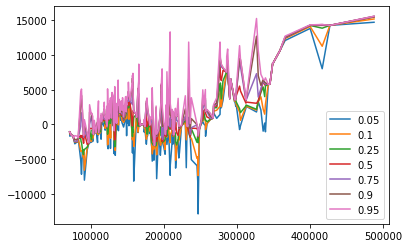

In [27]:
pd.DataFrame.from_dict(data = pred_resid_quantiles,
                       orient = 'index').sort_index(axis = 0).plot()

<AxesSubplot:>

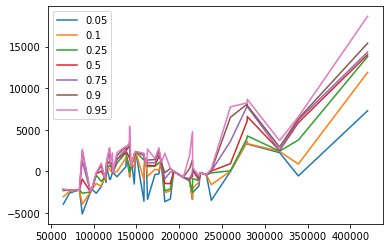

In [89]:
pd.DataFrame.from_dict(data = pred_resid_quantiles,
                       orient = 'index').sort_index(axis = 0).plot()


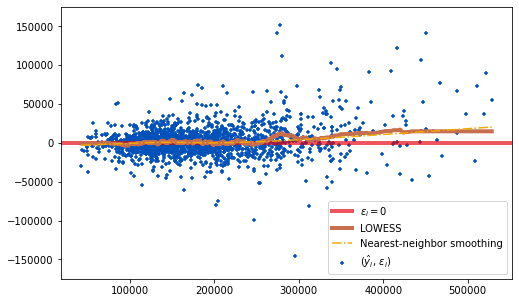

In [29]:
resid_fig, resid_ax = plt.subplots(nrows = 1,
                                   ncols = 1,
                                   figsize = (5 * golden, 5))
resid_ax.axhline(color = '#e8000daa',
                 label = '$\epsilon_i = 0$',
                 linewidth = 4)
resid_ax.scatter(pred_price_all,
                 pred_resid_all,
                 marker = '+',
                 s = 10,
                 color = '#0051ba',
                 label = '$(\hat{y}_i,\,\epsilon_i)$')
resid_ax.plot(ordered_resids['pred_price_all'],
              resid_kneighb_reg.predict(X = ordered_resids[['pred_price_scaled']]),
              color = '#c66e4e',
              linewidth = 4,
              label = 'LOWESS')
resid_ax.plot(resid_dist_lowess[:,0],
              resid_dist_lowess[:,1],
              color = '#f2a900',
              linestyle = '-.',
              linewidth = 1.5,
              label = 'Nearest-neighbor smoothing')
resid_ax.legend();
resid_ax.set_ylim(bottom = -175000,
                  top = 175000);

<AxesSubplot:>

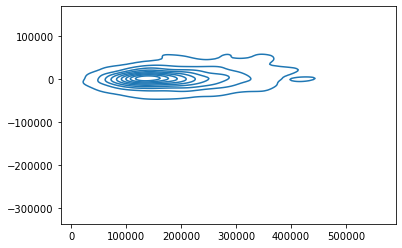

In [23]:
sns.kdeplot(y = pred_resid_all,
            x = pred_price_all)